In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA



2024-02-20 12:49:56.010067: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data = pd.read_csv('PTSD_filtered.csv')
data.head(10)

,freezing,genotype,id,day,condition,sex,cohort,exposure_mins,analyzed_duration,date,time,els,psilocybin,cohort_id,dob
0,5.03,wt,81,sefla,control,male,ptsd2,60.0,60.0,4/28/21,11:59 AM,n,n,ptsd2_81,2/16/21
1,0.45,wt,81,seflb,control,male,ptsd2,3.5,3.5,4/29/21,4:40 PM,n,n,ptsd2_81,2/16/21
2,8.28,wt,81,recall1,control,male,ptsd2,5.0,5.0,4/30/21,1:37 PM,n,n,ptsd2_81,2/16/21
3,7.12,wt,81,recall2,control,male,ptsd2,5.0,5.0,5/3/21,10:17 AM,n,n,ptsd2_81,2/16/21
4,7.57,wt,81,recall3,control,male,ptsd2,5.0,5.0,5/5/21,10:04 AM,n,n,ptsd2_81,2/16/21
5,6.61,wt,81,recall4,control,male,ptsd2,5.0,5.0,5/19/21,10:24 AM,n,n,ptsd2_81,2/16/21
6,3.92,wt,81,recall5,control,male,ptsd2,5.0,5.0,6/2/21,10:03 AM,n,n,ptsd2_81,2/16/21
7,8.83,wt,82,sefla,control,male,ptsd2,60.0,60.0,4/28/21,11:59 AM,n,n,ptsd2_82,2/16/21
8,4.20,wt,82,seflb,control,male,ptsd2,3.5,3.5,4/29/21,5:09 PM,n,n,ptsd2_82,2/16/21
9,28.80,wt,82,recall1,control,male,ptsd2,5.0,5.0,4/30/21,2:00 PM,n,n,ptsd2_82,2/16/21


In [3]:
# creating variable for relative time since each sefla
data['date'] = pd.to_datetime(data['date'])

data.sort_values(by=['id', 'date'], inplace=True)

data['days_since_sefla'] = None

for idx, row in data.iterrows():
    if row['day'] == 'sefla':
        data.at[idx, 'days_since_sefla'] = 0
    else:
        sefla_row = data[(data['id'] == row['id']) & (data['day'] == 'sefla')]
        if not sefla_row.empty:
            sefla_date = sefla_row.iloc[0]['date']
            days_since_sefla = (row['date'] - sefla_date).days
            data.at[idx, 'days_since_sefla'] = days_since_sefla

data.head()


/var/folders/nh/hjw01w5j4k7csj4x6k02jv000000gn/T/ipykernel_11618/1578901980.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['date'] = pd.to_datetime(data['date'])


,freezing,genotype,id,day,condition,sex,cohort,exposure_mins,analyzed_duration,date,time,els,psilocybin,cohort_id,dob,days_since_sefla
110,61.92,wt,1,sefla,sefl,male,ptsd3,60.0,60.0,2021-05-19,3:05 PM,n,n,ptsd3_1,1/15/21,0
111,36.73,wt,1,seflb,sefl,male,ptsd3,3.5,3.5,2021-05-20,10:09 AM,n,n,ptsd3_1,1/15/21,1
112,55.02,wt,1,recall1,sefl,male,ptsd3,5.0,5.0,2021-05-21,10:13 AM,n,n,ptsd3_1,1/15/21,2
113,46.33,wt,1,recall2,sefl,male,ptsd3,5.0,5.0,2021-05-24,2:29 PM,n,n,ptsd3_1,1/15/21,5
114,34.20,wt,1,recall3,sefl,male,ptsd3,5.0,5.0,2021-05-26,12:11 PM,n,n,ptsd3_1,1/15/21,7


In [4]:
#create a time variable for age in weeks since birth at each day 
data['dob'] = pd.to_datetime(data['dob'])
data['weeks_since_birth'] = (data['date'] - data['dob']).dt.days / 7

data['young'] = data['weeks_since_birth'] < 12
data.head()


/var/folders/nh/hjw01w5j4k7csj4x6k02jv000000gn/T/ipykernel_11618/2269198852.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['dob'] = pd.to_datetime(data['dob'])


,freezing,genotype,id,day,condition,sex,cohort,exposure_mins,analyzed_duration,date,time,els,psilocybin,cohort_id,dob,days_since_sefla,weeks_since_birth,young
110,61.92,wt,1,sefla,sefl,male,ptsd3,60.0,60.0,2021-05-19,3:05 PM,n,n,ptsd3_1,2021-01-15,0,17.714286,False
111,36.73,wt,1,seflb,sefl,male,ptsd3,3.5,3.5,2021-05-20,10:09 AM,n,n,ptsd3_1,2021-01-15,1,17.857143,False
112,55.02,wt,1,recall1,sefl,male,ptsd3,5.0,5.0,2021-05-21,10:13 AM,n,n,ptsd3_1,2021-01-15,2,18.000000,False
113,46.33,wt,1,recall2,sefl,male,ptsd3,5.0,5.0,2021-05-24,2:29 PM,n,n,ptsd3_1,2021-01-15,5,18.428571,False
114,34.20,wt,1,recall3,sefl,male,ptsd3,5.0,5.0,2021-05-26,12:11 PM,n,n,ptsd3_1,2021-01-15,7,18.714286,False


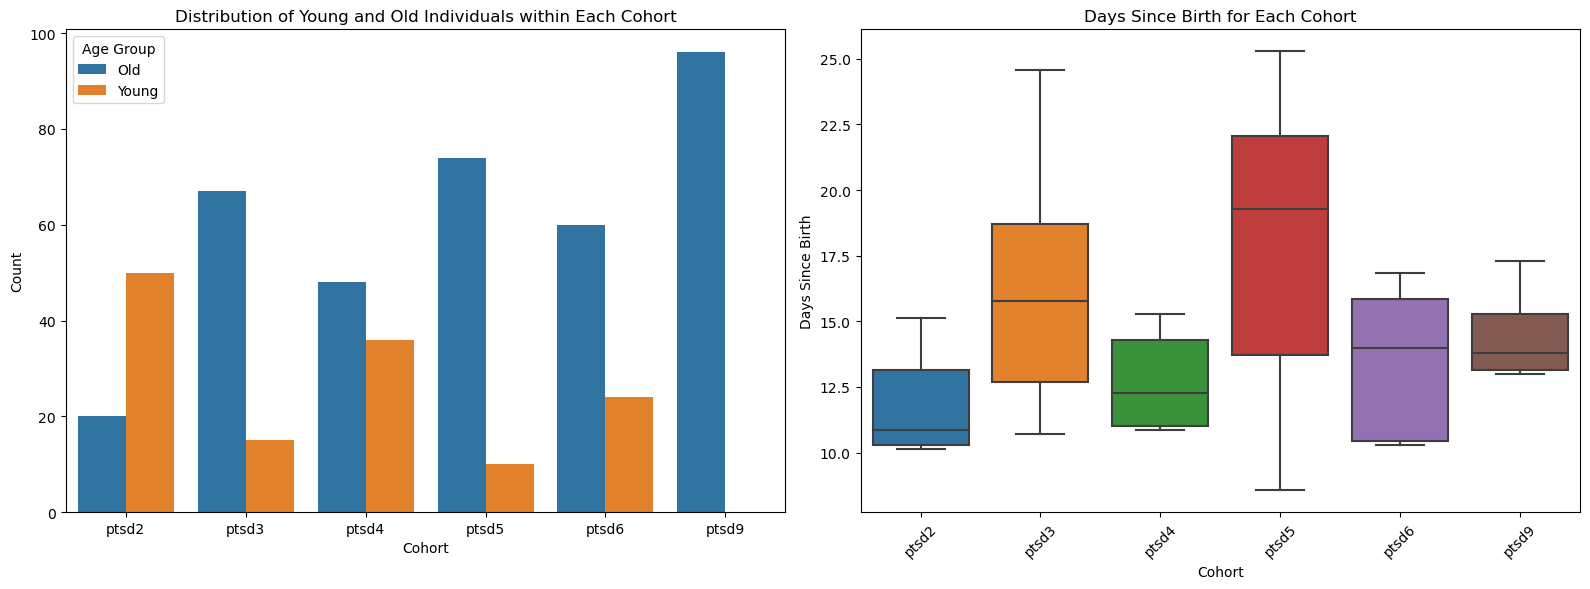

In [7]:
#overall age distribution for each cohort 
##old vs young for each cohort
plt.figure(figsize=(16, 6))  

# Plot 1: Distribution of Young and Old Individuals within Each Cohort
plt.subplot(1, 2, 1)  # Create a subplot with 1 row, 2 columns, and select the first plot
sns.countplot(data=data, x='cohort', hue='young', order=sorted(data['cohort'].unique()))
plt.xlabel('Cohort')
plt.ylabel('Count')
plt.title('Distribution of Young and Old Individuals within Each Cohort')
plt.legend(title='Age Group', labels=['Old', 'Young'])

# Plot 2: Days Since Birth for Each Cohort
plt.subplot(1, 2, 2)  
sns.boxplot(data=data, x='cohort', y='weeks_since_birth', order=sorted(data['cohort'].unique()))
plt.xlabel('Cohort')
plt.ylabel('Days Since Birth')
plt.title('Days Since Birth for Each Cohort')
plt.xticks(rotation=45)  
plt.tight_layout()  

plt.show()


                 sum_sq     df         F    PR(>F)
young       1558.813189    1.0  3.889189  0.049151
Residual  199601.761016  498.0       NaN       NaN


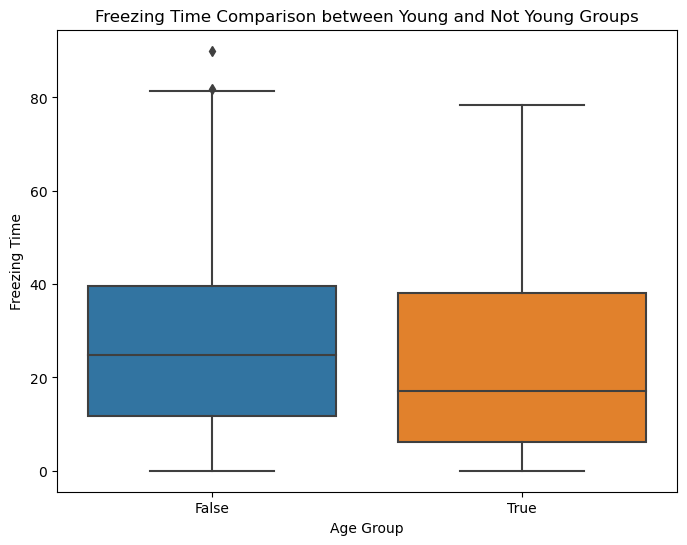

In [8]:
#anova analysis on age across the entire dataset (significant difference shown in the young vs. not young group)
model_young = ols('freezing ~ young', data=data).fit()
anova_table_young = sm.stats.anova_lm(model_young, typ=2)
print(anova_table_young)

young_data = data[data['young'] == True]
not_young_data = data[data['young'] == False]
combined_data = pd.concat([young_data, not_young_data])

plt.figure(figsize=(8, 6))
sns.boxplot(data=combined_data, x='young', y='freezing')
plt.xlabel('Age Group')
plt.ylabel('Freezing Time')
plt.title('Freezing Time Comparison between Young and Not Young Groups')
plt.show()




ANOVA for Cohort: ptsd2
                sum_sq    df         F    PR(>F)
young      1145.216604   1.0  6.614764  0.012303
Residual  11772.865025  68.0       NaN       NaN
ANOVA for Cohort: ptsd3
                sum_sq    df         F    PR(>F)
young      2814.698418   1.0  7.363322  0.008149
Residual  30580.745720  80.0       NaN       NaN
ANOVA for Cohort: ptsd4
                sum_sq    df         F    PR(>F)
young       232.982988   1.0  0.665387  0.417028
Residual  28712.032253  82.0       NaN       NaN
ANOVA for Cohort: ptsd5
                sum_sq    df         F    PR(>F)
young        20.102417   1.0  0.047549  0.827926
Residual  34667.361778  82.0       NaN       NaN
ANOVA for Cohort: ptsd6
                sum_sq    df         F    PR(>F)
young      2476.291741   1.0  8.192963  0.005336
Residual  24784.185729  82.0       NaN       NaN
ANOVA for Cohort: ptsd9
                sum_sq    df   F  PR(>F)
young              NaN   1.0 NaN     NaN
Residual  39295.770899  95.0 NaN     Na

/Users/novak/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/Users/novak/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1917: RuntimeWarning: invalid value encountered in divide
  F /= J


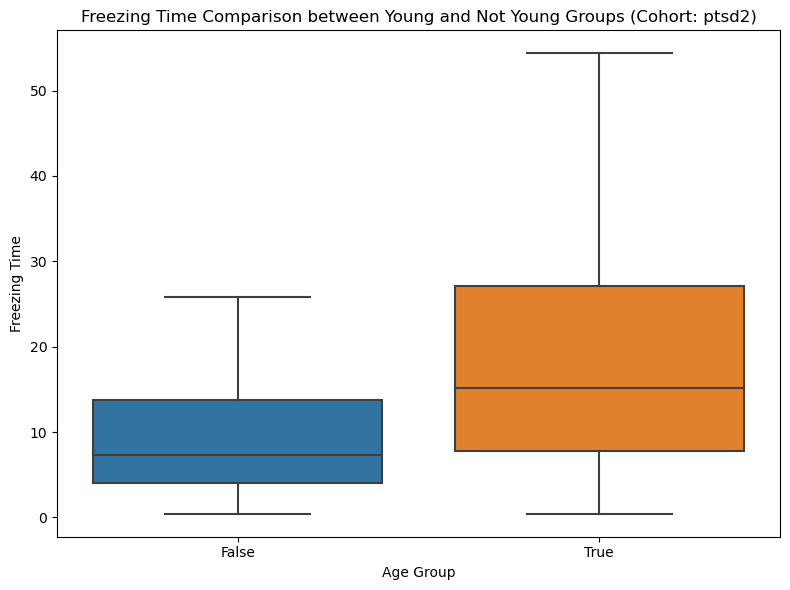

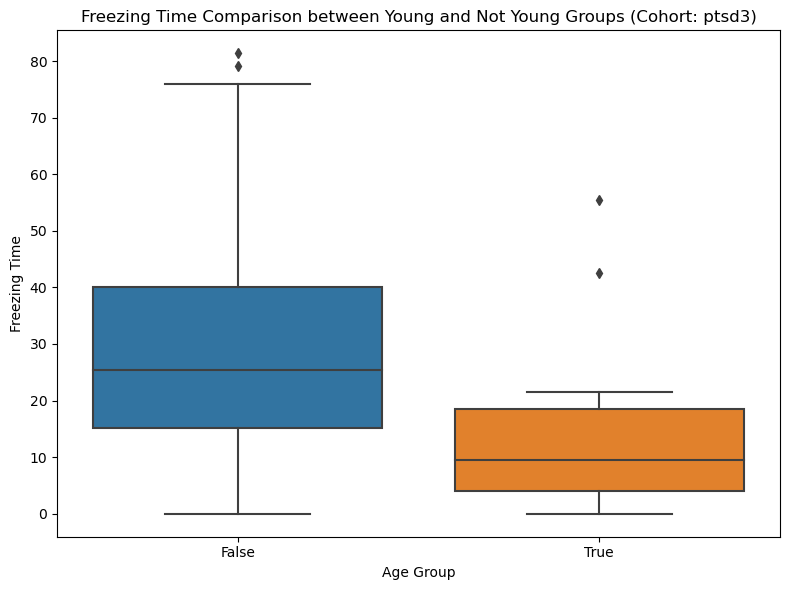

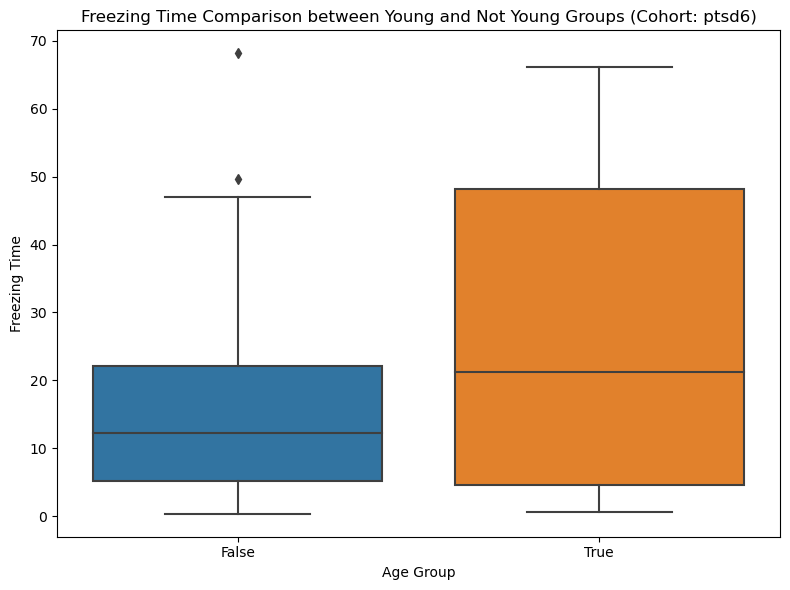

In [9]:
#anova on freezing time for each cohort 

cohorts = sorted(data['cohort'].unique())
anova_results = []

for cohort in cohorts:
    cohort_data = data[data['cohort'] == cohort]
    model = ols('freezing ~ young', data=cohort_data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    anova_results.append((cohort, anova_table))

for cohort, anova_table in sorted(anova_results, key=lambda x: x[0]):
    print(f"ANOVA for Cohort: {cohort}")
    print(anova_table)


for cohort, anova_table in sorted(anova_results, key=lambda x: x[0]):
    if anova_table['PR(>F)'][0] < 0.05:
        plt.figure(figsize=(8, 6))
        sns.boxplot(data=data[data['cohort'] == cohort], x='young', y='freezing')
        plt.xlabel('Age Group')
        plt.ylabel('Freezing Time')
        plt.title(f'Freezing Time Comparison between Young and Not Young Groups (Cohort: {cohort})')
        plt.tight_layout()  # Adjust layout for better readability
        plt.show()


ANOVA for Freezing Time within SEFL Group:
                sum_sq    df           F        PR(>F)
young     95586.742451   1.0  227.492322  5.719152e-25
Residual  33193.879249  79.0         NaN           NaN
ANOVA for Freezing Time within Control Group:
               sum_sq    df          F        PR(>F)
young     3513.922625   1.0  43.158817  2.057407e-08
Residual  4396.594575  54.0        NaN           NaN


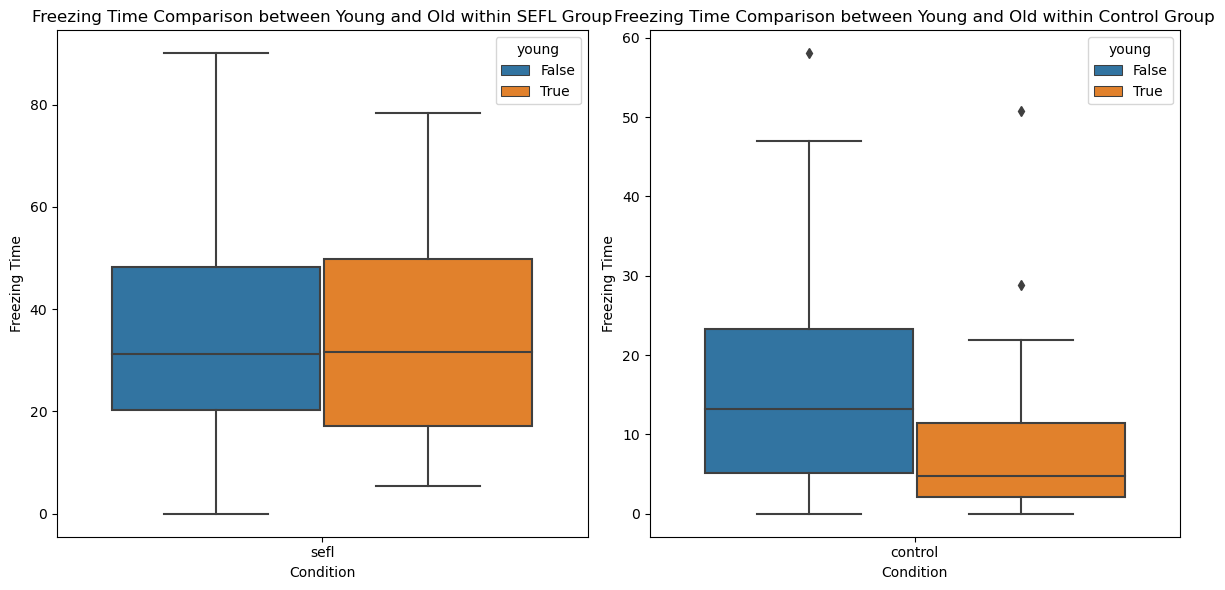

In [10]:
# ANOVA on freezing time between young and not young within each expeiemental group

## ANOVA on freezing time between young and not young within SEFL group
sefl_young_data = data[(data['young'] == True) & (data['condition'] == 'sefl')]
sefl_not_young_data = data[(data['young'] == False) & (data['condition'] == 'sefl')]

sefl_model = ols('freezing ~ young', data=sefl_young_data).fit()
sefl_anova_table = sm.stats.anova_lm(sefl_model, typ=2)
print("ANOVA for Freezing Time within SEFL Group:")
print(sefl_anova_table)

## ANOVA on freezing time between young and not young within control group
control_young_data = data[(data['young'] == True) & (data['condition'] == 'control')]
control_not_young_data = data[(data['young'] == False) & (data['condition'] == 'control')]

control_model = ols('freezing ~ young', data=control_young_data).fit()
control_anova_table = sm.stats.anova_lm(control_model, typ=2)
print("ANOVA for Freezing Time within Control Group:")
print(control_anova_table)

# Box plot comparisons
plt.figure(figsize=(12, 6))

# Box plot for SEFL group
plt.subplot(1, 2, 1)
sns.boxplot(data=data[data['condition'] == 'sefl'], x='condition', y='freezing', hue='young')
plt.xlabel('Condition')
plt.ylabel('Freezing Time')
plt.title('Freezing Time Comparison between Young and Old within SEFL Group')

# Box plot for control group
plt.subplot(1, 2, 2)
sns.boxplot(data=data[data['condition'] == 'control'], x='condition', y='freezing', hue='young')
plt.xlabel('Condition')
plt.ylabel('Freezing Time')
plt.title('Freezing Time Comparison between Young and Old within Control Group')

plt.tight_layout()
plt.show()



Multi-factor ANOVA for Freezing Time within SEFL Group:
                sum_sq     df          F        PR(>F)
cohort    24992.264373    5.0  15.761592  8.041903e-14
Residual  97675.634421  308.0        NaN           NaN
Multi-factor ANOVA for Freezing Time within Control Group:
                sum_sq     df       F    PR(>F)
cohort     4598.313994    5.0  7.7325  0.000001
Residual  21408.252114  180.0     NaN       NaN


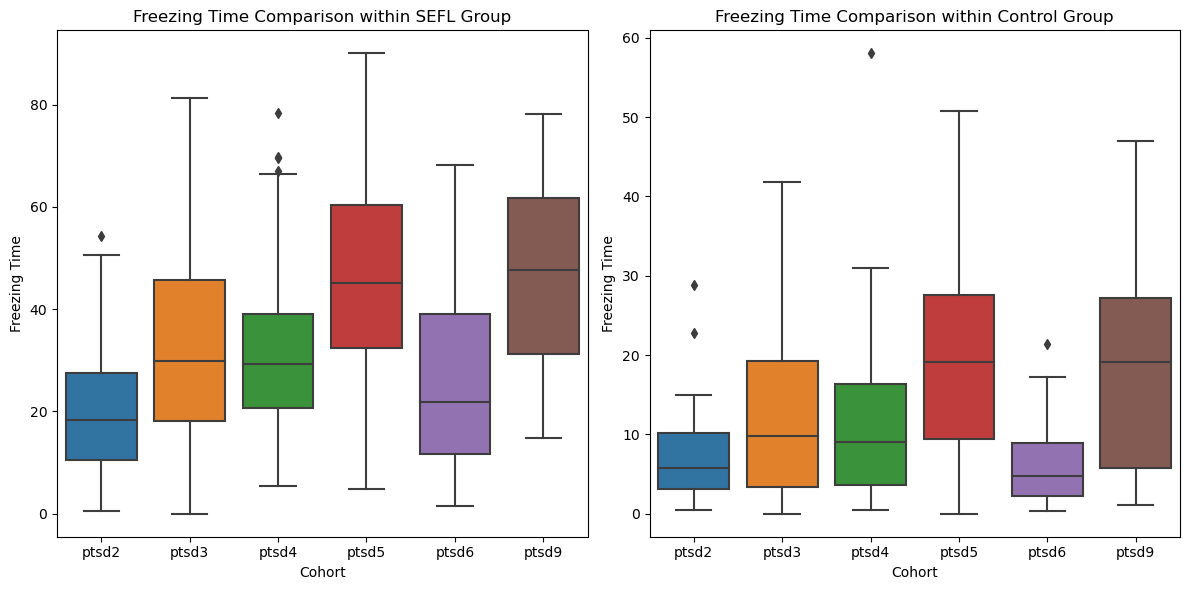

In [20]:
# Multi-factor ANOVA on freezing time within SEFL group
sefl_anova_model = ols('freezing ~ cohort', data=data[data['condition'] == 'sefl']).fit()
sefl_anova_table = sm.stats.anova_lm(sefl_anova_model, typ=2)
print("Multi-factor ANOVA for Freezing Time within SEFL Group:")
print(sefl_anova_table)

# Multi-factor ANOVA on freezing time within control group
control_anova_model = ols('freezing ~ cohort', data=data[data['condition'] == 'control']).fit()
control_anova_table = sm.stats.anova_lm(control_anova_model, typ=2)
print("Multi-factor ANOVA for Freezing Time within Control Group:")
print(control_anova_table)

plt.figure(figsize=(12, 6))

# Box plot for SEFL group
plt.subplot(1, 2, 1)
sns.boxplot(data=data[data['condition'] == 'sefl'], x='cohort', y='freezing', order=sorted(data['cohort'].unique()))
plt.xlabel('Cohort')
plt.ylabel('Freezing Time')
plt.title('Freezing Time Comparison within SEFL Group')

# Box plot for control group
plt.subplot(1, 2, 2)
sns.boxplot(data=data[data['condition'] == 'control'], x='cohort', y='freezing', order=sorted(data['cohort'].unique()))
plt.xlabel('Cohort')
plt.ylabel('Freezing Time')
plt.title('Freezing Time Comparison within Control Group')

plt.tight_layout()
plt.show()


In [15]:
sefl_groups = data[data['condition'] == 'sefl']
sefl_groups.tail()

,freezing,genotype,id,day,condition,sex,cohort,exposure_mins,analyzed_duration,date,time,els,psilocybin,cohort_id,dob,days_since_sefla,weeks_since_birth,young
58,49.51,wt,95,recall1,sefl,male,ptsd2,5.0,5.0,2021-04-30,2:17 PM,n,n,ptsd2_95,2021-02-16,2,10.428571,True
59,26.60,wt,95,recall2,sefl,male,ptsd2,5.0,5.0,2021-05-03,11:04 AM,n,n,ptsd2_95,2021-02-16,5,10.857143,True
60,21.40,wt,95,recall3,sefl,male,ptsd2,5.0,5.0,2021-05-05,10:43 AM,n,n,ptsd2_95,2021-02-16,7,11.142857,True
61,22.80,wt,95,recall4,sefl,male,ptsd2,5.0,5.0,2021-05-19,11:13 AM,n,n,ptsd2_95,2021-02-16,21,13.142857,False
62,4.19,wt,95,recall5,sefl,male,ptsd2,5.0,5.0,2021-06-02,10:49 AM,n,n,ptsd2_95,2021-02-16,35,15.142857,False


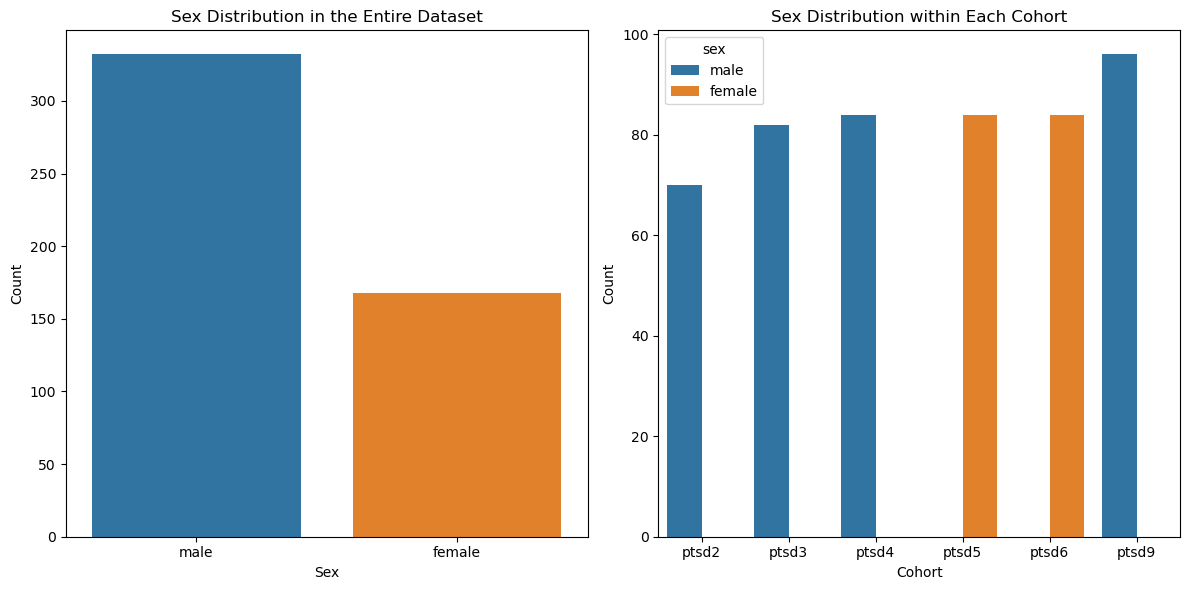

In [81]:
# Sex distribution in the entire dataset
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.countplot(data=data, x='sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.title('Sex Distribution in the Entire Dataset')

# Sex distribution within each cohort
plt.subplot(1, 2, 2)
sns.countplot(data=data, x='cohort', hue='sex', order=sorted(data['cohort'].unique()))
plt.xlabel('Cohort')
plt.ylabel('Count')
plt.title('Sex Distribution within Each Cohort')

plt.tight_layout()
plt.show()


                 sum_sq     df         F    PR(>F)
sex          920.016299    1.0  2.288088  0.131005
Residual  200240.557905  498.0       NaN       NaN
                 sum_sq     df         F    PR(>F)
sex          605.153051    1.0  1.546809  0.214541
Residual  122062.745743  312.0       NaN       NaN
                sum_sq     df         F    PR(>F)
sex          17.473013    1.0  0.123707  0.725451
Residual  25989.093095  184.0       NaN       NaN


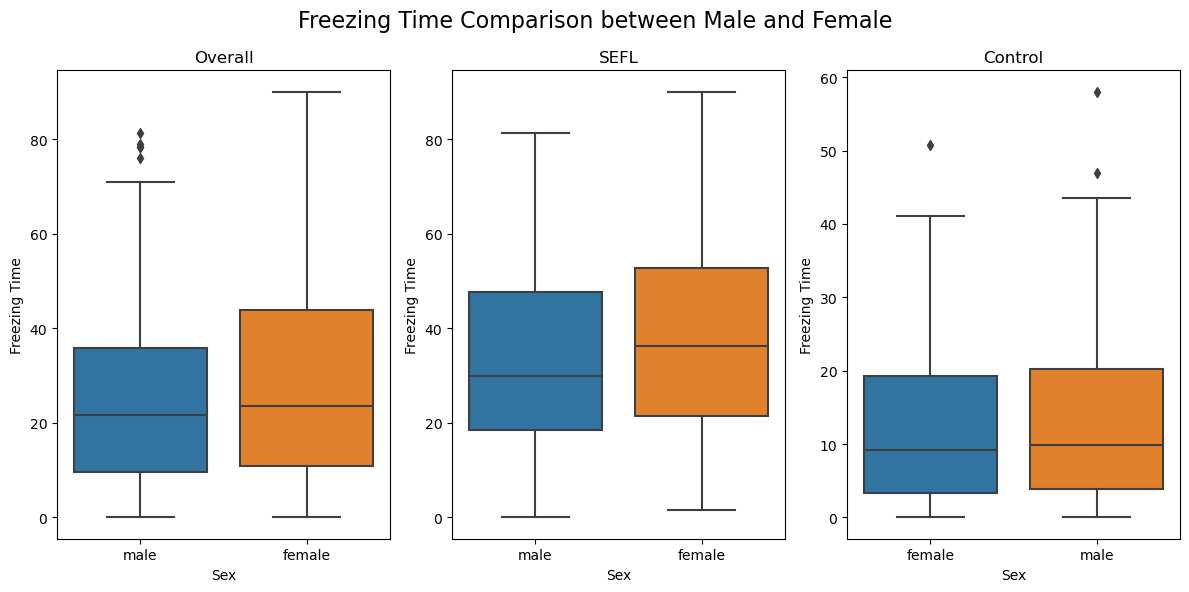

In [35]:
# anova on sex (no significant difference)
model_sex = ols('freezing ~ sex', data=data).fit()
anova_table_sex = sm.stats.anova_lm(model_sex, typ=2)
print(anova_table_sex)

sefl_data = data[data['condition'] == 'sefl']
model_sefl = ols('freezing ~ sex', data=sefl_data).fit()
anova_table_sefl = sm.stats.anova_lm(model_sefl, typ=2)
print(anova_table_sefl)

control_data = data[data['condition'] == 'control']
model_control = ols('freezing ~ sex', data=control_data).fit()
anova_table_control = sm.stats.anova_lm(model_control, typ=2)
print(anova_table_control)

plt.figure(figsize=(12, 6))

# Box plot for overall dataset
plt.subplot(1, 3, 1)
sns.boxplot(data=data, x='sex', y='freezing')
plt.xlabel('Sex')
plt.ylabel('Freezing Time')
plt.title('Overall')

# Box plot for SEFL group
plt.subplot(1, 3, 2)
sns.boxplot(data=sefl_data, x='sex', y='freezing')
plt.xlabel('Sex')
plt.ylabel('Freezing Time')
plt.title('SEFL')

# Box plot for control group
plt.subplot(1, 3, 3)
sns.boxplot(data=control_data, x='sex', y='freezing')
plt.xlabel('Sex')
plt.ylabel('Freezing Time')
plt.title('Control')

plt.suptitle('Freezing Time Comparison between Male and Female', fontsize=16)

plt.tight_layout()
plt.show()


                sum_sq     df         F    PR(>F)
sex        2597.223780    1.0  5.954865  0.015993
Residual  58008.164713  133.0       NaN       NaN
                 sum_sq     df        F    PR(>F)
sex            3.882783    1.0  0.01014  0.919844
Residual  138992.489739  363.0      NaN       NaN


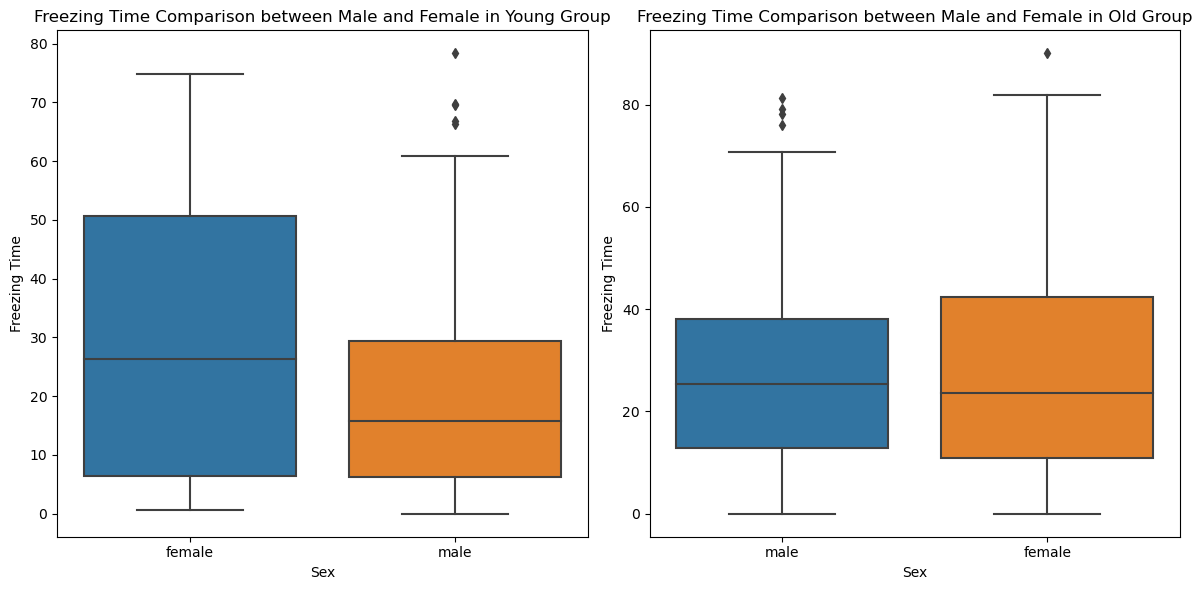

In [75]:
# ANOVA on freezing between sex, within each age group
young_data = data[data['young'] == True]

model_young_sex = ols('freezing ~ sex', data=young_data).fit()
anova_table_young_sex = sm.stats.anova_lm(model_young_sex, typ=2)
print(anova_table_young_sex)

not_young_data = data[data['young'] == False]

model_old_sex = ols('freezing ~ sex', data=not_young_data).fit()
anova_table_old_sex = sm.stats.anova_lm(model_old_sex, typ=2)
print(anova_table_old_sex)


plt.figure(figsize=(12, 6))

# Box plot for young group
plt.subplot(1, 2, 1)
sns.boxplot(data=young_data, x='sex', y='freezing')
plt.xlabel('Sex')
plt.ylabel('Freezing Time')
plt.title('Freezing Time Comparison between Male and Female in Young Group')

# Box plot for old group
plt.subplot(1, 2, 2)
sns.boxplot(data=not_young_data, x='sex', y='freezing')
plt.xlabel('Sex')
plt.ylabel('Freezing Time')
plt.title('Freezing Time Comparison between Male and Female in Old Group')

plt.tight_layout()
plt.show()


                 sum_sq     df          F        PR(>F)
cohort     24658.320632    5.0  13.802895  1.236559e-12
Residual  176502.253572  494.0        NaN           NaN


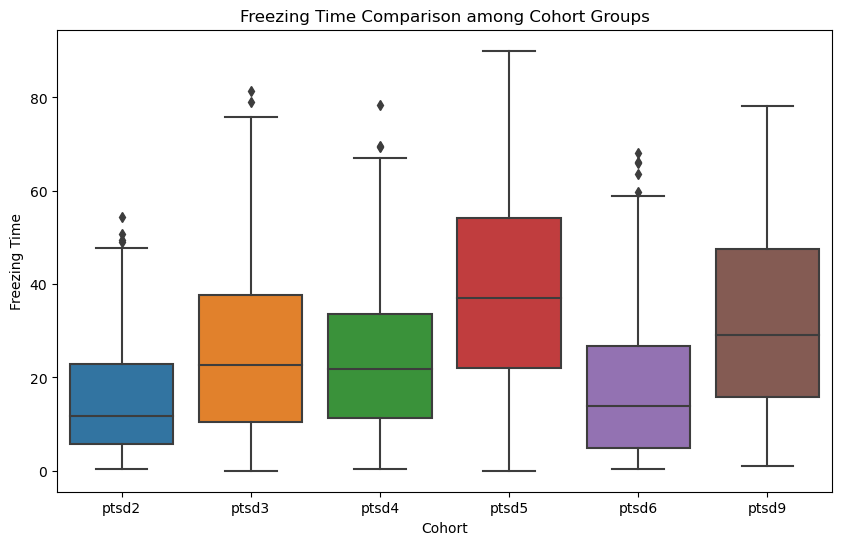

In [92]:
# ANOVA among all cohort groups

## Perform ANOVA analysis
model = ols('freezing ~ cohort', data=data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# Print the ANOVA table
print(anova_table)

# Generate box plot graphs
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='cohort', y='freezing', order=sorted(data['cohort'].unique()))
plt.xlabel('Cohort')
plt.ylabel('Freezing Time')
plt.title('Freezing Time Comparison among Cohort Groups')
plt.show()


In [36]:
data['time_of_day'] = data['time'].apply(lambda x: 'morning' if x.endswith('AM') else 'afternoon')


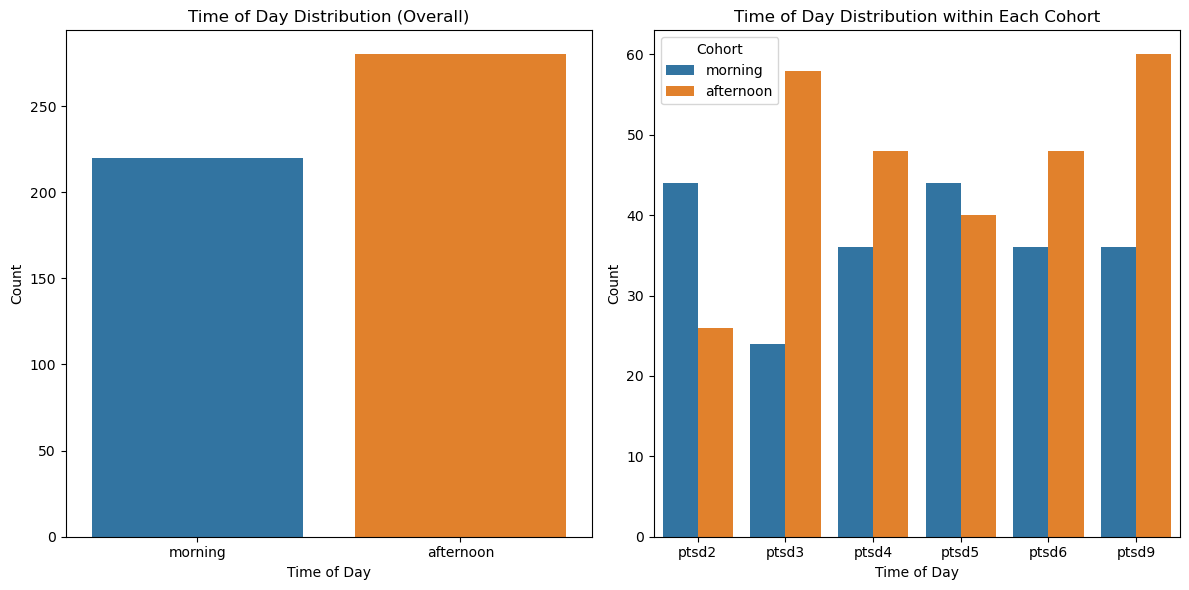

In [37]:
# Overall time of day distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(data=data, x='time_of_day', order=['morning', 'afternoon'])
plt.xlabel('Time of Day')
plt.ylabel('Count')
plt.title('Time of Day Distribution (Overall)')

# Time of day distribution within each cohort
plt.subplot(1, 2, 2)
sns.countplot(data=data, x='cohort', hue='time_of_day', order=sorted(data['cohort'].unique()), hue_order=['morning', 'afternoon'])
plt.xlabel('Time of Day')
plt.ylabel('Count')
plt.title('Time of Day Distribution within Each Cohort')
plt.legend(title='Cohort')

plt.tight_layout()
plt.show()


                    sum_sq     df          F    PR(>F)
time_of_day    4031.941122    1.0  10.185769  0.001505
Residual     197128.633082  498.0        NaN       NaN


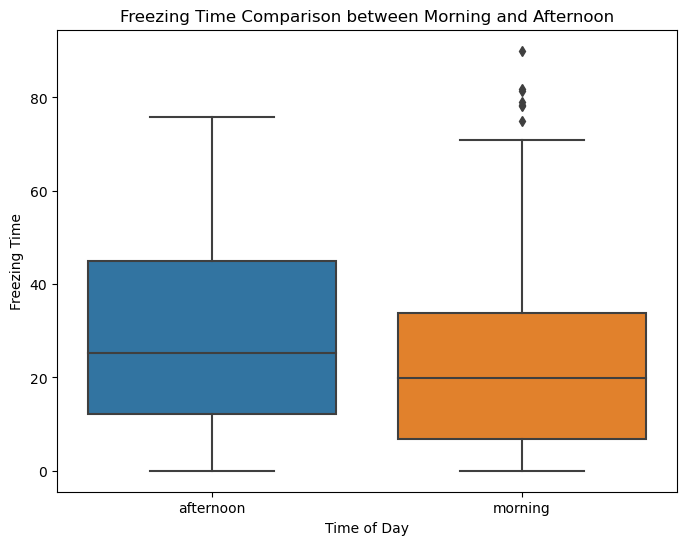

In [40]:
# ANOVA analysis
model_time = ols('freezing ~ time_of_day', data=data).fit()
anova_table_time = sm.stats.anova_lm(model_time, typ=2)
print(anova_table_time)

# Box plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='time_of_day', y='freezing')
plt.xlabel('Time of Day')
plt.ylabel('Freezing Time')
plt.title('Freezing Time Comparison between Morning and Afternoon')
plt.show()


ANOVA for Freezing Time in the Morning:
                 sum_sq     df          F        PR(>F)
condition  17212.086572    1.0  55.020308  2.624565e-12
Residual   68197.270827  218.0        NaN           NaN
ANOVA for Freezing Time in the Afternoon:
                 sum_sq     df          F        PR(>F)
condition  34551.419168    1.0  124.47274  3.933846e-24
Residual   77167.856517  278.0        NaN           NaN


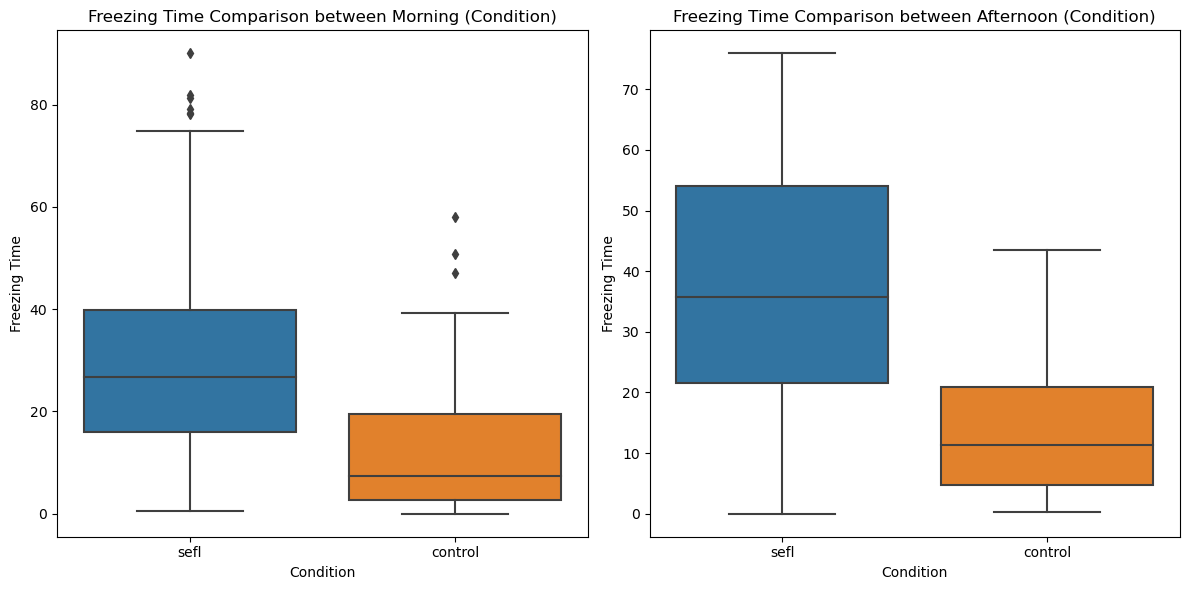

In [42]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Filter the data for morning and afternoon within each condition
morning_data = data[data['time_of_day'] == 'morning']
afternoon_data = data[data['time_of_day'] == 'afternoon']

# Perform ANOVA analysis within each condition
morning_model = ols('freezing ~ condition', data=morning_data).fit()
morning_anova_table = sm.stats.anova_lm(morning_model, typ=2)
print("ANOVA for Freezing Time in the Morning:")
print(morning_anova_table)

afternoon_model = ols('freezing ~ condition', data=afternoon_data).fit()
afternoon_anova_table = sm.stats.anova_lm(afternoon_model, typ=2)
print("ANOVA for Freezing Time in the Afternoon:")
print(afternoon_anova_table)

plt.figure(figsize=(12, 6))

# Box plot for morning data
plt.subplot(1, 2, 1)
sns.boxplot(data=morning_data, x='condition', y='freezing')
plt.xlabel('Condition')
plt.ylabel('Freezing Time')
plt.title('Freezing Time Comparison between Morning (Condition)')

# Box plot for afternoon data
plt.subplot(1, 2, 2)
sns.boxplot(data=afternoon_data, x='condition', y='freezing')
plt.xlabel('Condition')
plt.ylabel('Freezing Time')
plt.title('Freezing Time Comparison between Afternoon (Condition)')

plt.tight_layout()
plt.show()


ANOVA for Freezing Time within Cohort ptsd2:
                  sum_sq    df          F    PR(>F)
time_of_day  3126.544184   1.0  21.713138  0.000015
Residual     9791.537445  68.0        NaN       NaN
ANOVA for Freezing Time within Cohort ptsd3:
                   sum_sq    df         F   PR(>F)
time_of_day    313.346470   1.0  0.757743  0.38664
Residual     33082.097668  80.0       NaN      NaN
ANOVA for Freezing Time within Cohort ptsd4:
                   sum_sq    df         F    PR(>F)
time_of_day     87.597344   1.0  0.248913  0.619177
Residual     28857.417898  82.0       NaN       NaN
ANOVA for Freezing Time within Cohort ptsd5:
                   sum_sq    df         F    PR(>F)
time_of_day    187.752320   1.0  0.446256  0.505994
Residual     34499.711875  82.0       NaN       NaN
ANOVA for Freezing Time within Cohort ptsd6:
                   sum_sq    df        F    PR(>F)
time_of_day   2597.564183   1.0  8.63646  0.004278
Residual     24662.913287  82.0      NaN       NaN
A

<Figure size 640x480 with 0 Axes>

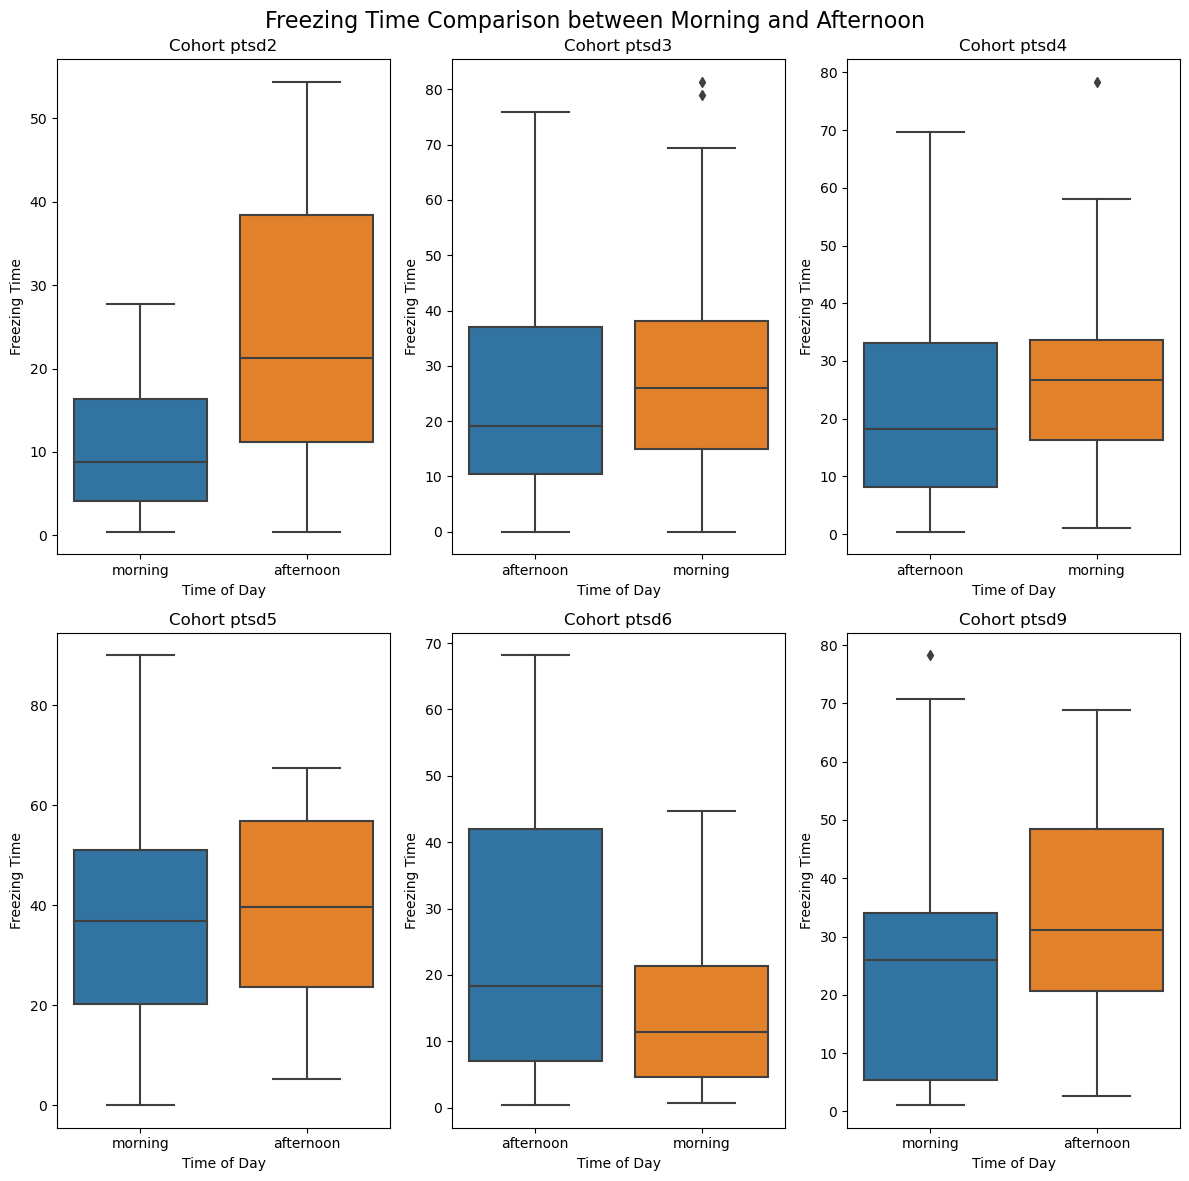

In [55]:
# Filter the data for morning and afternoon within each cohort
morning_data = data[data['time_of_day'] == 'morning']
afternoon_data = data[data['time_of_day'] == 'afternoon']

# Perform ANOVA analysis within each cohort
anova_results = []

for cohort in sorted(data['cohort'].unique()):
    cohort_morning_data = morning_data[morning_data['cohort'] == cohort]
    cohort_afternoon_data = afternoon_data[afternoon_data['cohort'] == cohort]
    
    model = ols('freezing ~ time_of_day', data=pd.concat([cohort_morning_data, cohort_afternoon_data])).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    anova_results.append((cohort, anova_table))

for cohort, anova_table in sorted(anova_results, key=lambda x: x[0]):
    print(f"ANOVA for Freezing Time within Cohort {cohort}:")
    print(anova_table)


plt.tight_layout()
plt.figure(figsize=(12, 12))  # Adjust the figure size to accommodate the new layout

cohorts = sorted(data['cohort'].unique())

for i, cohort in enumerate(cohorts):
    cohort_data = data[data['cohort'] == cohort]
    
    plt.subplot(2, 3, i+1)  # Adjust the subplot layout to 2 rows and 3 columns
    sns.boxplot(data=cohort_data, x='time_of_day', y='freezing')
    plt.xlabel('Time of Day')
    plt.ylabel('Freezing Time')
    plt.title(f'Cohort {cohort}')

plt.suptitle('Freezing Time Comparison between Morning and Afternoon', fontsize=16)

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Freezing Time Comparison between Morning and Afternoon in Cohort ptsd9 (by Condition)')

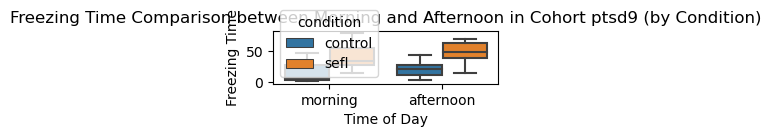

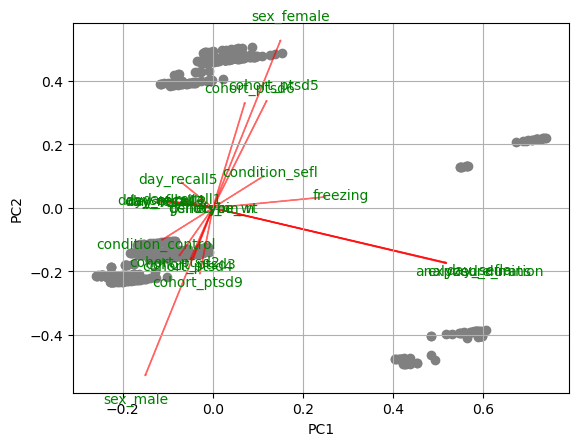

In [10]:
numerical_cols = ['freezing', 'exposure_mins', 'analyzed_duration']
categorical_cols = ['genotype', 'day', 'condition', 'sex', 'cohort', 'els', 'psilocybin']

numerical_data = data[numerical_cols]
dummy_data = pd.get_dummies(data[categorical_cols])
pca_data = pd.concat([numerical_data, dummy_data], axis=1)

scaler = StandardScaler()
pca_data_scaled = scaler.fit_transform(pca_data)

pca = PCA()
pca_result = pca.fit_transform(pca_data_scaled)
explained_variance = pca.explained_variance_ratio_


def biplot(score, coeff, labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    
    plt.scatter(xs * scalex, ys * scaley, c='gray')
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], color='red', alpha=0.5)
        if labels is not None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color='green', ha='center', va='center')
    
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

# Assuming pca_result is the PCA result and pca_data_scaled is the scaled dataset
biplot(pca_result[:, :2], np.transpose(pca.components_[:2, :]), labels=pca_data.columns)

plt.show()





ModuleNotFoundError: No module named 'adjustText'

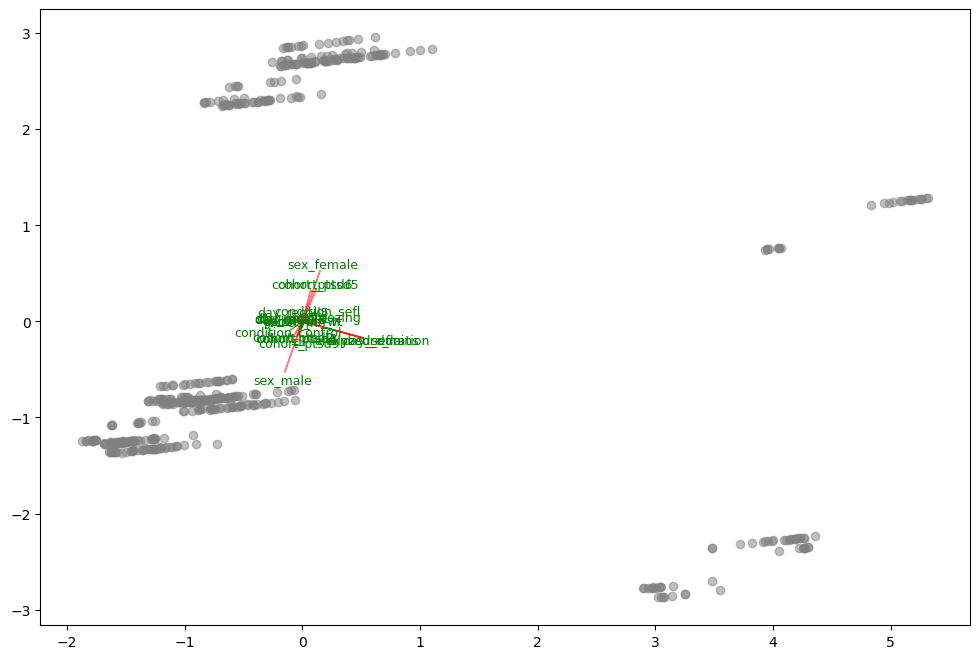

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Function to adjust text annotations to minimize overlap in the biplot
def adjust_text(texts, x_values, y_values):
    from adjustText import adjust_text  # Make sure to install the package with 'pip install adjustText'
    adjust_text(texts, x_values, y_values, arrowprops=dict(arrowstyle='->', color='red'))

# Create an enhanced biplot function
def enhanced_biplot(score, coeff, labels=None, biplot_scale=1):
    xs = score[:,0] * biplot_scale
    ys = score[:,1] * biplot_scale
    n = coeff.shape[0]
    
    # Scaling the arrows by a factor for better visibility
    coeff_scaled = coeff * biplot_scale
    
    plt.figure(figsize=(12, 8))  # Increase figure size
    plt.scatter(xs, ys, c='gray', alpha=0.5)  # Add transparency to points
    
    texts = []
    for i in range(n):
        plt.arrow(0, 0, coeff_scaled[i,0], coeff_scaled[i,1], color='red', alpha=0.5)
        if labels is not None:
            text = plt.text(coeff_scaled[i,0]* 1.15, coeff_scaled[i,1] * 1.15, labels[i], color='green', ha='center', va='center', fontsize=9)
            texts.append(text)
    
    # Adjust text annotations to minimize overlap
    adjust_text(texts, xs, ys)
    
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Enhanced PCA Biplot")
    plt.grid(True)
    plt.axis('equal')  # Ensure the scale of PC1 and PC2 is the same
    
    plt.show()

# Sample usage with your PCA results (make sure pca_result and pca are defined in your context)
enhanced_biplot(pca_result[:, :2], np.transpose(pca.components_[:2, :]), labels=pca_data.columns, biplot_scale=1)


/var/folders/nh/hjw01w5j4k7csj4x6k02jv000000gn/T/ipykernel_3682/3594893092.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=data, x='day', y='freezing', hue='id', marker='o', palette='tab20', ci=None, legend=False)


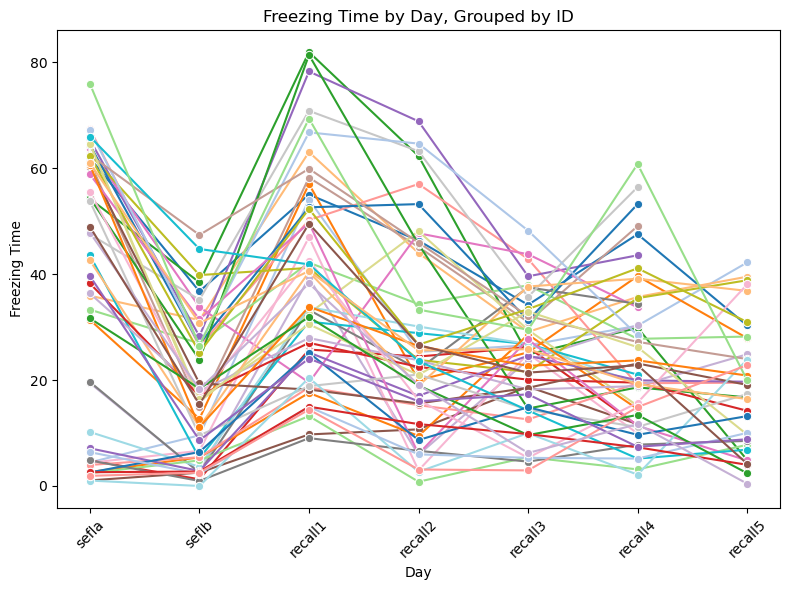

In [44]:
# freezing time by day in terms of stage of the experiment 
plt.figure(figsize=(8, 6))
sns.lineplot(data=data, x='day', y='freezing', hue='id', marker='o', palette='tab20', ci=None, legend=False)

plt.title('Freezing Time by Day, Grouped by ID')
plt.xlabel('Day')
plt.ylabel('Freezing Time')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability

# Show the plot without the legend
plt.tight_layout()
plt.show()


In [50]:
# import pandas as pd
# from statsmodels.tsa.seasonal import seasonal_decompose
# import matplotlib.pyplot as plt

# # Make a copy of the original dataset
# data_copy = data.copy()

# # Convert 'day' to a categorical type with ordered levels if not already done
# data_copy['day'] = pd.Categorical(data_copy['day'], categories=[
#     'sefla', 'seflb', 'recall1', 'recall2', 'recall3', 'recall4'], ordered=True)

# # Sort data by 'day' to ensure it's in the correct order
# data_copy.sort_values(by='day', inplace=True)

# # For demonstration, we'll assume each 'day' represents a sequential and regular time step
# # This is a simplification and may not accurately reflect your actual dataset's time structure

# # Reset index to ensure it's continuous if filtering or operations have disrupted it
# data_copy.reset_index(drop=True, inplace=True)

# # Apply seasonal_decompose assuming a simplistic regular frequency
# # Note: You should adjust 'period' to match the actual seasonal cycle in your data if known
# results = seasonal_decompose(data_copy['freezing'], model='additive', period=1)  # Adjust 'period' as needed
# results.plot()

# # Show the plot
# plt.show()
